<div style="display: flex; background-color: RGB(119, 150, 203);">
    <h1 style="margin: auto; padding: 30px 30px 30px 30px; color: RGB(255,255,255);"> 
        <center>
            <b>Algorithmique et Python</b><br/>
            <u>PROD : The TripAdvisor Hotel Project<br/> 
        </center>
        <br/>
        <p style="text-align:center;">
            <img src="https://static.tacdn.com/img2/brand_refresh/Tripadvisor_lockup_horizontal_secondary_registered.svg" alt="TripAdvisor logo" width="400" height="400" align="center">
        </p>
        <center>
            Réalisé par Claire Gefflot, Romain Pénichon,<br/> Mohamed Ghazali, Mehdi Aiyad et Abdelkabir Menani<br/>
        </center>        
</div>

<a class="anchor" id="table_of_contents"></a>
## Table of contents

* [Chapitre 1 : Chapitre 1 : Importation des modèles (sentiment et NER) et mise en place des fonctions pour la mise en production](#chapter1)
<br>
* [Chapitre 2 : Analyse statistique des avis d'hôtels : ce que les clients apprécient et ce qui peut être amélioré](#chapter2)
<br>

<a class="anchor" id="chapter1"></a>
<div style="background-color: RGB(119, 150, 203);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Chapitre 1 : Importation des modèles (sentiment et NER) et mise en place des fonctions pour la mise en production</h2>
</div>

La mise en place de ces fonctions vont nous permettre d'appliquer les modèles de sentiment et de NER sur les différents commentaires de l'hôtel. On aura en output quatre nouvelle colonnes (en plus de la database qui est importée) : 2 colonnes dont une pour les "points forts"(fort) et une pour les "points faibles"(faible) (par éléments, ex : bed, staff, etc...). 2 colonnes dont une pour les compliments (fort_score) et une pour les critiques (faible_score), chaque catégorie(bedroom, bathroom, service, restaurant, location, price) aura un score par commentaire (ex : Pour la colonne fort_score, si dans le commentaire il y a 3 mots qui appartiennent à la catégorie "bedroom" et 0 mot pour les autres catégories, alors on attribura un score de 3 pour la catégorie bedroom et 0 pour les autres catégories). Ces résultats seront ensuite utilisés pour faire des analyses statistiques.

On a décidé de lancer l'algorithme seulement sur les 30 premier commentaires car la procédure risque d'être trop longue.

In [ ]:
#Importation de la donnée
import pandas as pd
path = '...\\Data\\'
df = pd.read_excel(path + 'reviews_google.xlsx').drop('index', axis=1)

In [3]:
#On va appliquer seulment sur les 30 premiere observations
df2 = df.iloc[:20,:]
df2

NameError: name 'df' is not defined

In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [ ]:
from transformers import BertTokenizer
import torch
import onnx
import onnxruntime as ort

class_names = ['positive','negative', 'neutral']
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
ort_sess = ort.InferenceSession('...\\modele_sentiment_BERT\\torch-model.onnx')


In [ ]:
def infer_onnx_model(review_text__):
    encoded_review = tokenizer.encode_plus(
                              review_text__,
                              max_length=512,
                              add_special_tokens=True,
                              return_token_type_ids=False,
                              pad_to_max_length=True,
                              return_attention_mask=True,
                              return_tensors='pt',
                            )
    outputs = ort_sess.run(None, {'input_ids': encoded_review['input_ids'].cpu().detach().numpy(),
                              'attention_mask':encoded_review['attention_mask'].cpu().detach().numpy()})
    outputs = torch.from_numpy(outputs[0])
    _, prediction = torch.max(outputs, dim=1)
    return class_names[prediction]

In [ ]:
#list of point fort and point faible : 
import numpy as np
import re


#NER BERT :
from simpletransformers.ner import NERModel,NERArgs
from simpletransformers.ner import NERModel

#le path pour charger le modèle
path_BERT_NER ='...\\modele_NER_BERT\\NER_BERT_Model'
model2 = NERModel("bert", path_BERT_NER, use_cuda=False)

#Ce code définit une fonction fort_faible() qui prend en argument une chaîne de caractères text et qui renvoie une liste de 
#dictionnaires contenant des mots et leurs étiquettes de nommage d'entités.
def fort_faible(text : str) :
    text = text.lower() #la chaîne de caractères est convertie en minuscule
    #on séprare en différentes phrases en utilisant une expression régulière
    text = re.split(r'[\.!?;,]| but | whereas | yet | althought | though | still | furthermore | moreover | even though | on the other hand | in spite of ', text)
    #Ensuite, la fonction crée une liste vide appelée list_word qui sera utilisée pour stocker les mots et leurs étiquettes.
    list_word = []
    
    #Pour chaque phrase dans text, la fonction calcule un score de sentiment en utilisant le modèle model et en appelant la 
    #méthode polarity_scores(). Si le score est supérieur à 0,3, la fonction crée un nouveau modèle appelé model2 qui sera 
    #utilisé pour détecter les entités nommées dans la phrase. La fonction utilise alors le modèle model2 pour prédire les entités 
    #nommées dans la phrase et stocke le résultat dans une variable pred.
    for phrase in text :
        score = infer_onnx_model(phrase) 
        
        if score == 'positive' :
            prediction, model_output = model2.predict([phrase])
            pred = prediction
            
            #Enfin, la fonction itère sur chaque mot et étiquette dans pred et ajoute le mot et son étiquette à la liste 
            #list_word s'il n'est pas marqué comme "O", c'est-à-dire s'il n'est pas une entité nommée.
            i=0
            while i < len(pred[0]) :
                word, label = pred[0][i].popitem()
                word_label = {}
                
                if label != 'O':
                    word_label[word] = label
                    list_word.append(word_label) 
                i+=1
                
    #La fonction renvoie finalement list_word.           
    return list_word 
 
df2['fort'] = df2['review'].apply(fort_faible)





#Même commentaire que pour la fonction fort_faible, sauf que là on classe les points faibles
def fort_faible2(text : list) :
    text = text.lower()
    text = re.split(r'[\.!?;,]| but | whereas | yet | althought | though | still | furthermore | moreover | even though | on the other hand | in spite of ', text)
    list_word = []
    
    for phrase in text :
        score = infer_onnx_model(phrase) 
        
        if score == 'negative' :
            prediction, model_output = model2.predict([phrase])
            pred = prediction
            
            i=0
            while i < len(pred[0]) :
                word, label = pred[0][i].popitem()
                word_label = {}
                    
                if label != 'O':
                    word_label[word] = label
                    list_word.append(word_label) 
            
                i+=1
                
    return list_word 

df2['faible'] = df2['review'].apply(fort_faible2)


In [ ]:
def group_point(word_list): #e code définit une fonction group_point qui prend en entrée une liste de mots (word_list).
    #La fonction initialise plusieurs variables à 0 (bedroom, bathroom, service, location, restaurant, price) qui serviront à compter le nombre d'occurrences de chaque mot dans la liste.
    bedroom = 0
    bathroom = 0
    service = 0
    location = 0
    restaurant = 0
    price = 0
    
    #La fonction définit également un dictionnaire vide (Dict_score) qui sera utilisé pour stocker le résultat final.
    Dict_score = {}
    
    #Ensuite, la fonction itère sur chaque mot de la liste (for i in word_list) et utilise la fonction next() avec l'itérable 
    #iter(i) pour récupérer la première clé du dictionnaire i. Le label de chaque mot est alors récupéré en accédant à la valeur associée à cette clé 
    for i in word_list :
        label = i[next(iter(i))]
        #Ensuite, la fonction utilise une série d'instructions if-elif pour incrémenter le compteur associé à chaque mot (bedroom, bathroom, service, etc.) 
        #en fonction de sa catégorie (bedroom, bathroom, service, etc.).
        if label == "bedroom" :
            bedroom = bedroom + 1
        elif label == "bathroom":
            bathroom = bathroom + 1
        elif label == "service":
            service = service + 1
        elif label == "location":
            location = location + 1
        elif label == "restaurant":
            restaurant = restaurant + 1
        elif label == "price":
            price = price + 1
    
    #Enfin, la fonction utilise la méthode update() du dictionnaire Dict_score pour ajouter les compteurs de chaque mot dans le dictionnaire résultat.
    Dict_score.update({"bedroom" : bedroom, "bathroom": bathroom, "service": service, "location": location, "restaurant": restaurant, "price": price}) 
    
    #La fonction retourne ce dictionnaire en fin d'exécution.
    return Dict_score  
  
df2['fort_score'] = df2['fort'].apply(group_point)
df2['faible_score'] = df2['faible'].apply(group_point)

In [ ]:
#df2.to_excel('.../Data/hotel_review_result_output.xlsx')

<a class="anchor" id="chapter2"></a>
<div style="background-color: RGB(119, 150, 203);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Chapitre 2 : Analyse statistique des avis d'hôtels : ce que les clients apprécient et ce qui peut être amélioré</h2>
</div>

L'analyse statistique est une technique utilisée pour résumer, interpréter et comprendre les données. Elle permet de découvrir des relations, des tendances et des patterns dans les données, et d'utiliser ces informations pour prendre des décisions ou faire des prévisions. L'analyse statistique peut être très utile pour un hôtel, car elle peut lui fournir de précieuses informations sur ce que pensent les clients de l'hôtel et sur les aspects de l'hôtel qui sont les plus appréciés ou qui ont besoin d'amélioration. Elle peut également aider l'hôtel à mieux comprendre les tendances dans les avis des clients et à prendre des décisions éclairées sur la façon de gérer l'hôtel pour améliorer l'expérience des clients.

In [137]:
#ICI, df2 = hotel_review_result_output.xlsx

import pandas as pd
df = pd.read_excel('.../Data/hotel_review_result_output.xlsx')

In [183]:
df.head(2)

,Unnamed: 0,title,review,rate,trip_type,date,fort,faible,fort_score,faible_score
0,0,small room but okey,"this hotel has the smallest room, and we have ...",4,traveled as a couple,2022-11-01,"[{'check': 'service'}, {'location': 'location'...",[],"{'bedroom': 0, 'bathroom': 0, 'service': 1, 'l...","{'bedroom': 0, 'bathroom': 0, 'service': 0, 'l..."
1,1,"great location, great staff",great location and simple but clean ammenities...,5,traveled on business,2022-10-01,"[{'location': 'location'}, {'staff': 'service'...",[],"{'bedroom': 2, 'bathroom': 0, 'service': 1, 'l...","{'bedroom': 0, 'bathroom': 0, 'service': 0, 'l..."


In [187]:
import matplotlib.pyplot as plt

def plot_rate_column(data):
    # Extract the rate column from the data
    rate_column = data['rate']

    # Create a histogram plot of the rate column
    plt.hist(rate_column, color='c')
    plt.xlabel('Note')
    plt.ylabel('Nombre de commentaire')
    plt.title('Distribution des notes')
    plt.show()


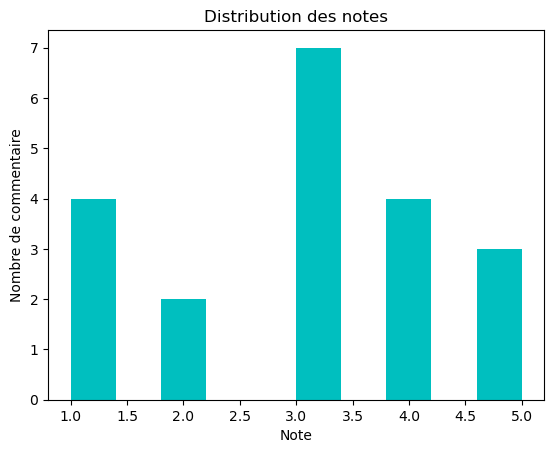

In [188]:
plot_rate_column(df)

In [141]:
def plot_trip_type_column(data):
  # Extract the trip_type column from the data
  trip_type_column = data['trip_type']

  # Create a pie chart plot of the trip_type column
  trip_type_counts = trip_type_column.value_counts()
  plt.pie(trip_type_counts, labels=trip_type_counts.index, autopct='%1.1f%%', textprops={'color':'black'})
  plt.title('Trip Types',fontweight='bold')
  plt.show()


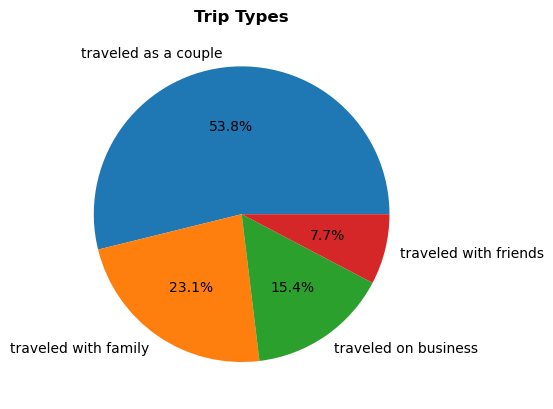

In [142]:
plot_trip_type_column(df)

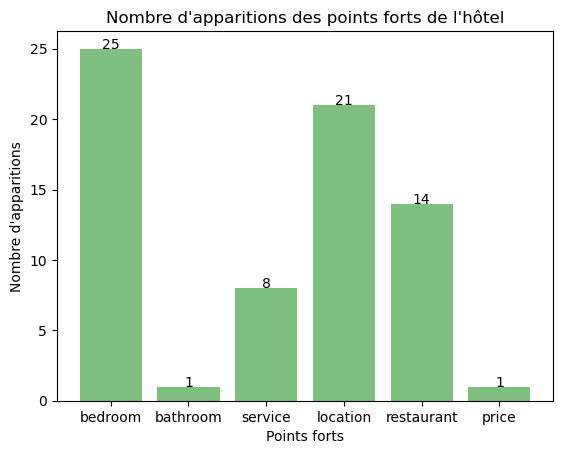

In [191]:
# Score_fort

import ast
import matplotlib.pyplot as plt

def count_keywords_fort(df):
    keywords_count = {}
    
    for index, row in df.iterrows():
        # Convertir la valeur de la colonne fort_score en dictionnaire
        score = ast.literal_eval(row['fort_score'])
        
        for keyword, count in score.items():
            if keyword not in keywords_count:
                keywords_count[keyword] = 0
            keywords_count[keyword] += count
    
    return keywords_count

# Compter le nombre d'apparitions de chaque mot-clé
keywords_count_fort = count_keywords_fort(df)

# Récupérer les mots-clés et leur nombre d'apparitions sous forme de listes
keywords = list(keywords_count_fort.keys())
counts = list(keywords_count_fort.values())

# Créer l'histogramme
plt.bar(keywords, counts, color='g', alpha=0.5, label='Keywords')

# Ajouter le nombre d'apparitions de chaque mot-clé sur chaque barre
for i, v in enumerate(counts):
    # Centrer le texte sur la barre
    plt.text(i, v, str(v), ha='center')

# Ajouter un titre et des étiquettes aux axes
plt.title("Nombre d'apparitions des points forts de l'hôtel")
plt.xlabel("Points forts")
plt.ylabel("Nombre d'apparitions")

# Afficher l'histogramme
plt.show()

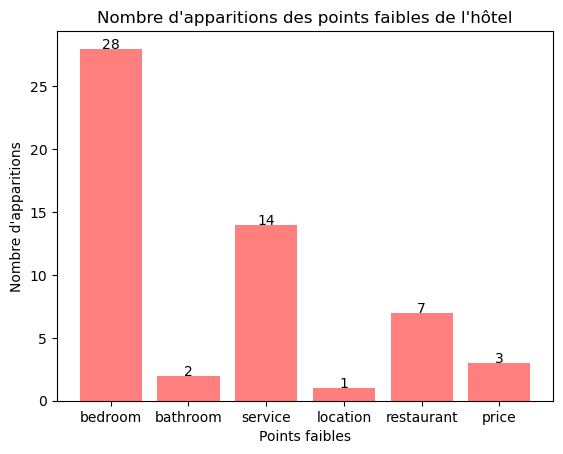

In [192]:
# Score_faible

import ast
import matplotlib.pyplot as plt

def count_keywords_faible(df):
    keywords_count = {}
    
    for index, row in df.iterrows():
        # Convertir la valeur de la colonne fort_score en dictionnaire
        score = ast.literal_eval(row['faible_score'])
        
        for keyword, count in score.items():
            if keyword not in keywords_count:
                keywords_count[keyword] = 0
            keywords_count[keyword] += count
    
    return keywords_count

# Compter le nombre d'apparitions de chaque mot-clé
keywords_count_faible = count_keywords_faible(df)

# Récupérer les mots-clés et leur nombre d'apparitions sous forme de listes
keywords = list(keywords_count_faible.keys())
counts = list(keywords_count_faible.values())

# Créer l'histogramme
plt.bar(keywords, counts, color='r', alpha=0.5, label='Keywords')

# Ajouter le nombre d'apparitions de chaque mot-clé sur chaque barre
for i, v in enumerate(counts):
    # Centrer le texte sur la barre
    plt.text(i, v, str(v), ha='center')

# Ajouter un titre et des étiquettes aux axes
plt.title("Nombre d'apparitions des points faibles de l'hôtel")
plt.xlabel("Points faibles")
plt.ylabel("Nombre d'apparitions")

# Afficher l'histogramme
plt.show()

## Comparing the occurences of positive and negative elements in the hotel

In [312]:
df.head(2)

,Unnamed: 0,title,review,rate,trip_type,date,fort,faible,fort_score,faible_score
0,0,small room but okey,"this hotel has the smallest room, and we have ...",4,traveled as a couple,2022-11-01,"[{'check': 'service'}, {'location': 'location'...",[],"{'bedroom': 0, 'bathroom': 0, 'service': 1, 'l...","{'bedroom': 0, 'bathroom': 0, 'service': 0, 'l..."
1,1,"great location, great staff",great location and simple but clean ammenities...,5,traveled on business,2022-10-01,"[{'location': 'location'}, {'staff': 'service'...",[],"{'bedroom': 2, 'bathroom': 0, 'service': 1, 'l...","{'bedroom': 0, 'bathroom': 0, 'service': 0, 'l..."


In [313]:
df.fort_score=df.fort_score.apply(lambda x:ast.literal_eval(x) )
df.faible_score=df.faible_score.apply(lambda x:ast.literal_eval(x) )

In [318]:
from collections import defaultdict

# Initialize a dictionary with default values of 0
fort_counts = defaultdict(int)

# Iterate over the rows in the fort_score column
for row in df['fort_score']:
    for word, count in row.items():
        # Update the count for each word
        fort_counts[word] += count



In [317]:
from collections import defaultdict

# Initialize a dictionary with default values of 0
faible_counts = defaultdict(int)

# Iterate over the rows in the fort_score column
for row in df['faible_score']:
    for word, count in row.items():
        # Update the count for each word
        faible_counts[word] += count



In [319]:
faible_counts

defaultdict(int,
            {'bedroom': 28,
             'bathroom': 2,
             'service': 14,
             'location': 1,
             'restaurant': 7,
             'price': 3})

In [320]:
fort_counts

defaultdict(int,
            {'bedroom': 25,
             'bathroom': 1,
             'service': 8,
             'location': 21,
             'restaurant': 14,
             'price': 1})

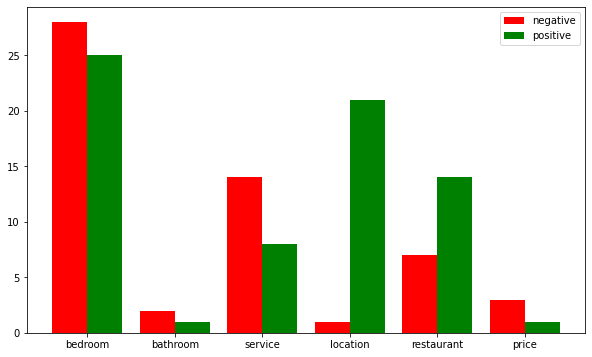

In [323]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
# Get the list of words
words = list(faible_counts.keys())

# Get the list of negative counts
faible_counts_values = list(faible_counts.values())

# Get the list of positive counts
fort_counts_values = list(fort_counts.values())

# Set the bar width
bar_width = 0.4

# Set the position of the bar
r1 = [x for x in range(len(words))]
r2 = [x + bar_width for x in r1]

# Create the plot
plt.bar(r1, faible_counts_values, width=bar_width, color='red', label='negative')
plt.bar(r2, fort_counts_values, width=bar_width, color='green', label='positive')

# Add the x-axis labels
plt.xticks([r + bar_width/2 for r in r1], words)

# Add a legend
plt.legend()

# Show the plot
plt.show()
